##  Linear regression - Boston housing prices

1. Title: Boston Housing Data

2. Relevant Information:
   Concerns housing values in suburbs of Boston.

3. Number of Instances: 506

4. Number of Attributes: 13 continuous attributes (including "class" attribute "MEDV"), 1 binary-valued attribute.

5. Attribute Information:
    1. CRIM      per capita crime rate by town
    2. ZN        proportion of residential land zoned for lots over 25,000 sq.ft.
    3. INDUS     proportion of non-retail business acres per town
    4. CHAS      Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
    5. NOX       nitric oxides concentration (parts per 10 million)
    6. RM        average number of rooms per dwelling
    7. AGE       proportion of owner-occupied units built prior to 1940
    8. DIS       weighted distances to five Boston employment centres
    9. RAD       index of accessibility to radial highways
    10. TAX      full-value property-tax rate per USD 1000  
    11. PTRATIO  pupil-teacher ratio by town
    12. B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks y town
    13. LSTAT    % lower status of the population
    14. MEDV     Median value of owner-occupied homes in USD 1000's
6. Missing Attribute Values:  None.


16 data points have an 'MEDV' value of 50.0. These data points likely contain missing or censored values and have been removed.
1 data point has an 'RM' value of 8.78. This data point can be considered an outlier and has been removed.
The features 'RM', 'LSTAT', 'PTRATIO', and 'MEDV' are essential. The remaining non-relevant features have been excluded.

In [1]:
import os
import math
import datetime

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer

from mlsettings.settings import load_app_config, get_datafolder_path
from mltools.mlcommon import load_data, print_dataset_info, split_dataset, auto_scatter_simple

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np


% matplotlib inline 

In [2]:
load_app_config()
DIRECTORY="boston"
FILENAME ='housing.csv'
RESPONSE="MEDV"
input_path = get_datafolder_path()

{'UAT': {'ML_PATH': 'F:\\MachineLearning', 'ML_DATASOURCE': 'F:\\DataSource'}, 'PRD': {'ML_PATH': 'F:\\MachineLearning', 'ML_DATASOURCE': 'F:\\DataSource'}, 'DEV': {'ML_PATH': 'F:\\MachineLearning', 'ML_DATASOURCE': 'F:\\DataSource'}, 'REG': {'ML_PATH': 'F:\\MachineLearning', 'ML_DATASOURCE': 'F:\\DataSource'}}
Adding F:\MachineLearning  to system path
Adding F:\DataSource  to system path


In [3]:
def load_dataset(filename=FILENAME,response=RESPONSE):
    input_file = os.path.join(input_path, DIRECTORY, filename)
    input_dataset = load_data(input_file)
    print(" input file is :{0} loaded.".format(input_file))
    #print(input_dataset.head())
    
    try:
        continuous_vars = input_dataset.describe().columns
        print("Continous Variables")
        print(continuous_vars)
    except ValueError:
        print("No continous variables")
    
    try:
        categorical_vars = input_dataset.describe(include=["object"]).columns
        print("Categorical Variables")
        print(categorical_vars)
    except ValueError:
        print("No categorical variables")
        categorical_vars = None
    
    response_column =  [col for col in input_dataset.columns if response in col]
    feature_columns =  [col for col in input_dataset.columns if response not in col]
            
    
    return  input_dataset,feature_columns,response_column

#### 2. Summarize Data
a) Descriptive statistics
b) Data visualizations

In [4]:
def display_data_descriptives(input_dataset,X,feature_columns,y,response_column):
    print("<{0} {1} {0}>".format("="*40,"feature columns"))
    print(feature_columns)
    print("<{0} {1} {0}>".format("="*40,"data header"))
    print(X.head().to_string())
    print("<{0} {1} {0}>".format("="*40,"response"))
    print(response_column)
    print("<{0} {1} {0}>".format("="*40,"Descriptive Statistics -X"))
    print(X.describe())
    print("<{0} {1} {0}>".format("="*40,"Descriptive Statistics -y"))
    print(y.describe())
    #print("<{0} {1} {0}>".format("="*40,"value_count -y"))
    #print(y.value_counts())
    print("<{0} {1} {0}>".format("="*40,"Correlation"))
    print(input_dataset.corr(method='pearson'))

In [5]:
input_dataset,feature_columns,response_column = load_dataset(filename=FILENAME,response=RESPONSE)
X = input_dataset[feature_columns]
y = input_dataset[response_column]
pd.set_option('display.width', 120)
pd.set_option('precision', 4)
display_data_descriptives(input_dataset,X,feature_columns,y,response_column)

 input file is :F:\DataSource\boston\housing.csv loaded.
Continous Variables
Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT', 'MEDV'],
      dtype='object')
No categorical variables
<======================================== feature columns ========================================>
['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']
<======================================== data header ========================================>
     CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  PTRATIO       B  LSTAT
0  0.0063  18.0   2.31   0.0  0.538  6.575  65.2  4.0900    1  296.0     15.3  396.90   4.98
1  0.0273   0.0   7.07   0.0  0.469  6.421  78.9  4.9671    2  242.0     17.8  396.90   9.14
2  0.0273   0.0   7.07   0.0  0.469  7.185  61.1  4.9671    2  242.0     17.8  392.83   4.03
3  0.0324   0.0   2.18   0.0  0.458  6.998  45.8  6.0622    3  222.0     18.7  394.63   2.

In [6]:
input_dataset=input_dataset.dropna()

In [7]:
def plot_hist(input_dataset,feature_columns,response_column,nbins=10):
    all_columns= feature_columns+response_column
    fig = plt.figure(figsize=(14,14))
    rows,col = input_dataset.shape
    print(col)
    for i in range(col):
        ax = fig.add_subplot(4, 4, i+1)
        sns.distplot(input_dataset[all_columns[i]] ,bins = nbins,kde =False)
        ax.set_title(all_columns[i])
    plt.tight_layout()

14


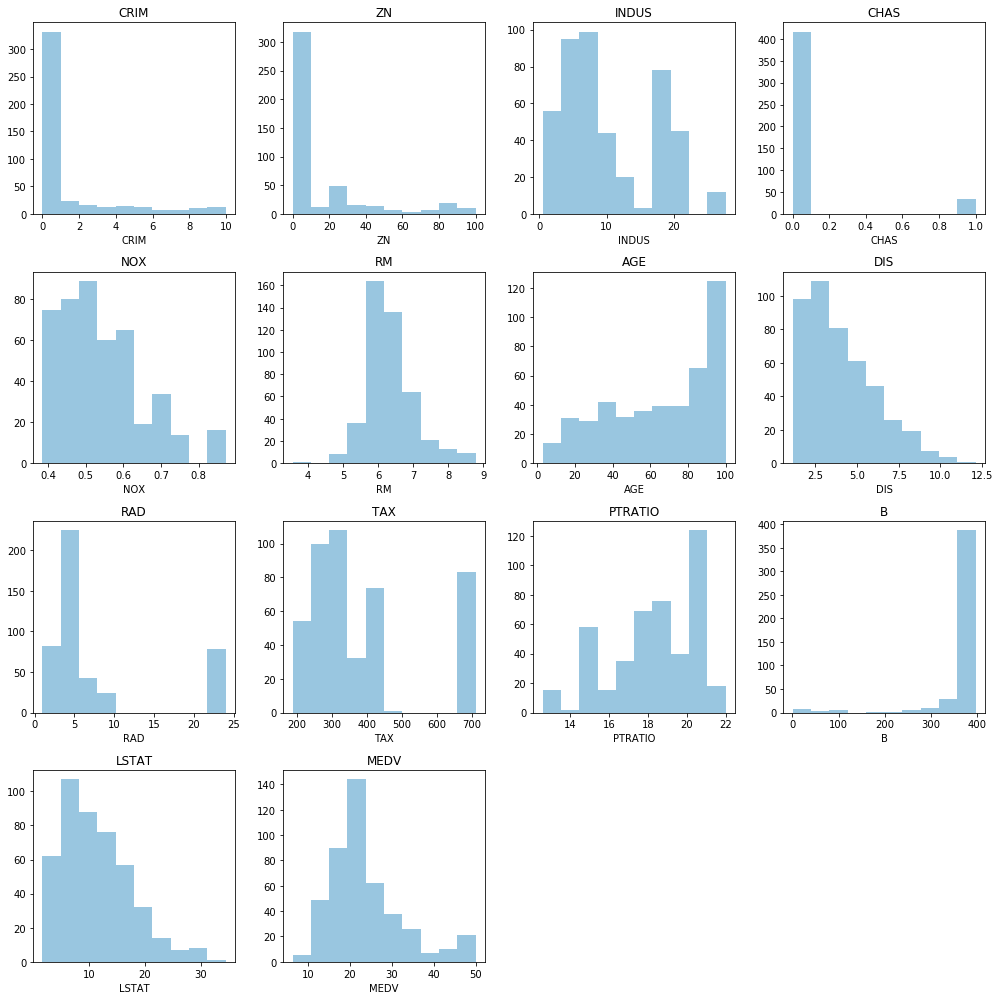

In [8]:
#sns.set(color_codes=True)

#sns.set_palette(sns.color_palette("BuGn_r"))
plt.style.use('seaborn-colorblind')
plot_hist(input_dataset,feature_columns,response_column,10)


In [9]:
def plot_hist_m(input_dataset,feature_columns,response_column,nbins=10):
    all_columns= feature_columns+response_column
    fig = plt.figure(figsize=(14,12))
    rows,col = input_dataset.shape
    for i in range(col):
        ax = fig.add_subplot(4, 4, i+1)
        ax.hist(input_dataset[all_columns[i]], bins=nbins, histtype='stepfilled', color='cornflowerblue' ,edgecolor='hotpink')
        ax.set_title(all_columns[i])
    plt.tight_layout()

In [10]:

#sns.pairplot(input_dataset, x_vars=feature_columns, y_vars="MEDV", kind="reg")
def plot_scatter(input_dataset,feature_columns,response_column):
    all_columns= feature_columns+response_column
    fig = plt.figure(figsize=(14,12))
    rows,col = input_dataset.shape
    for i in range(col-1):
        ax = fig.add_subplot(4,4, i+1)
        ax.scatter(input_dataset.iloc[:,i],input_dataset[response_column],marker=".")
        ax.set_title("{0} vs {1}".format(feature_columns[i],response_column))   
        
    
    plt.tight_layout()

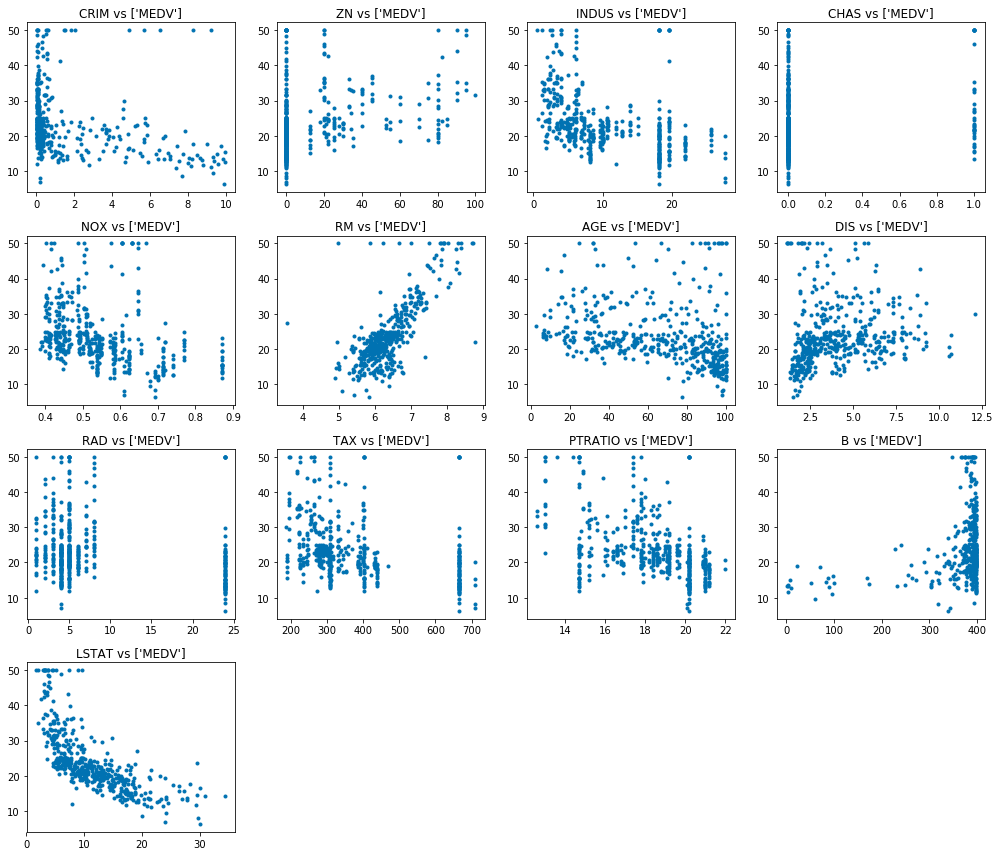

In [11]:
plot_scatter(input_dataset,feature_columns,response_column)

### Data cleaning
#####  removing  NA entries

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('Ridge', Ridge()))
model = Pipeline(estimators)
# evaluate pipeline
kfold = KFold(n_splits=10, random_state=7)
 
input_dataset =input_dataset.dropna(axis=0)
X = input_dataset[feature_columns]
y = input_dataset[response_column] 
results = cross_val_score(model, X, y.values.ravel(), cv=kfold)
print(results)
print(results.mean())

[ 0.75830489  0.36349962  0.75323775  0.75056079  0.63945417  0.76214573
  0.76073258  0.50556245 -0.18259037  0.28208065]
0.539298825848


#### Since results are  not encouraging we will check for any correlations causing issue

In [13]:
def plot_heatmap(input_dataset,feature_columns,response_column):
    sns.set(font_scale=1.5)
    cm=input_dataset.corr('pearson')
    f, ax = plt.subplots(figsize=(12,9))
    hm = sns.heatmap(cm,cbar=True,annot=True,square=True,annot_kws={'size': 15},
                     yticklabels=feature_columns+response_column,xticklabels=feature_columns+response_column)
    plt.show()

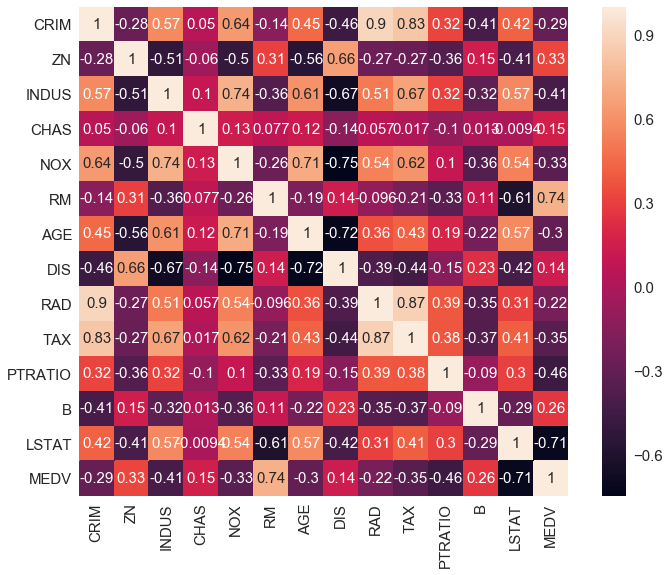

In [14]:
plot_heatmap(input_dataset,feature_columns,response_column)

In [15]:
# import  sklearn regression  packages
from sklearn.model_selection import  train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error

In [16]:
test_size = 0.20
seed =7
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=test_size, random_state=seed)

#### Evaluvate Algorithms

In [17]:
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))

In [20]:
results = []
names = []
folds =10
scoring = 'r2'
for name , model in models:
    kfold = KFold(n_splits= folds,random_state=seed )
    cv_results  = cross_val_score(model,X_train,y_train.values.ravel(),cv =kfold,scoring =scoring)
    results.append(cv_results)
    names.append(name)
    result_message = "{0} has r2 mean score {1}  with std {2} ".format(name,cv_results.mean(),cv_results.std())
    print(result_message)

LR has r2 mean score 0.676554331205098  with std 0.16749401270939632 
LASSO has r2 mean score 0.6456143684611293  with std 0.09063682923443933 
EN has r2 mean score 0.6319404514947806  with std 0.08183326489373122 
KNN has r2 mean score 0.35091044631091856  with std 0.18662142666894502 
CART has r2 mean score 0.7380514464672799  with std 0.07986524359074902 
SVR has r2 mean score -0.045778129137613054  with std 0.06115641558879825 
